# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, **Neptun ID**, and task details below.

**Name:** Kiss Tamás

**Neptun ID:** BLNF84

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [ ]:
# Fix to work on colab
#!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 torchtext==0.17 --index-url https://download.pytorch.org/whl/cu121

In [5]:
import os
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from nltk.tokenize import word_tokenize
from PIL import Image
from typing import Tuple, Dict, List, Literal

# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [ ]:
# !pip install -q kaggle

# from google.colab import files
# files.upload()

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d adityajn105/flickr8k

# !unzip flickr8k.zip -d flickr8k

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

In [6]:
class FlickrTokenizer:
    def __init__(self, captions: List[str], freq_threshold:int=5) -> None:
        self.freq_threshold:int = freq_threshold
        self.vocab_encode:Dict[str, int] = {}
        self.vocab_decode:Dict[int, str] = {}
        self.unk_token:str = 'UNK'
        self.sos_token:str = 'SOS'
        self.eos_token:str = 'EOS'
        self.pad_token:str = 'PAD'
        self.unk_token_id:int = 0
        self.sos_token_id:int = 1
        self.eos_token_id:int = 2
        self.pad_token_id:int = 3

        self.init_vocab(captions)

    def init_vocab(self, captions: List[str]) -> None:
        word_counter = {}

        for caption in captions:
            words = word_tokenize(caption)
            for word in words:
                if word not in word_counter:
                    word_counter[word] = 1
                else:
                    word_counter[word] += 1
        
        self.vocab_encode = {
            self.unk_token: self.unk_token_id,
            self.sos_token: self.sos_token_id,
            self.eos_token: self.eos_token_id, 
            self.pad_token: self.pad_token_id
        }

        idx = 4
        for token, count in word_counter.items():
            if count >= self.freq_threshold:
                self.vocab_encode[token] = idx
                idx += 1

        self.vocab_decode = {v: k for k, v in self.vocab_encode.items()}

    def encode(self, caption: str) -> torch.tensor:
        caption = self.sos_token + ' ' + caption + ' ' + self.eos_token
        return [self.vocab_encode.get(token, self.vocab_encode[self.unk_token]) for token in word_tokenize(caption)]
    
    def decode(self, tokens: torch.tensor) -> List[str]:
        return [self.vocab_decode[token] if token not in [self.sos_token_id, self.eos_token_id, self.pad_token_id] else '' for token in tokens.tolist()]
    
    def get_vocab(self) -> List[Dict[str, int]]:
        return [{word: token} for word, token in self.vocab_encode.items()]


In [7]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir: str, captions_file: str, split:Literal['whole', 'train', 'test', 'val']='whole',transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.captions_file = captions_file
        self.transform = transform

        # Load captions
        df = pd.read_csv(os.path.join(self.root_dir, self.captions_file), names=['image', 'caption'])
        self.idx_file = df
        df = df[1:]
        self.captions = df['caption'].tolist()

        # Init tokenizer
        self.freq_threshold = freq_threshold
        self.tokenizer = FlickrTokenizer(self.captions, freq_threshold=self.freq_threshold)
        
        # Set up splits
        self.split = split
        self.train_min_idx = 1
        self.train_max_idx = int(len(self.captions) * 0.8)

        self.test_min_idx = self.train_max_idx + 1
        self.test_max_idx = int(self.test_min_idx + len(self.captions) * 0.1)

        self.val_min_idx = self.test_max_idx + 1
        self.val_max_idx = len(self.captions) - 1

        # Get longest caption of the whole dataset
        self.max_caption_length = max([len(self.tokenizer.encode(caption)) for caption in self.captions])

    def __len__(self):
        match self.split:
            case 'train':
                return self.train_max_idx
            case 'test':
                return self.test_max_idx - self.train_max_idx
            case 'val':
                return self.val_max_idx - self.test_max_idx
            case 'whole':
                return len(self.captions)

    def __getitem__(self, idx):
        # 0-th item is the headers
        idx = idx+1
        match self.split:
            case 'train':
                if not (self.train_min_idx <= idx <= self.train_max_idx): raise IndexError('Index out of range')
            case 'test':
                idx = idx + self.train_max_idx
                if not (self.test_min_idx <= idx <= self.test_max_idx): raise IndexError('Index out of range')
            case 'val':
                idx = idx + self.test_max_idx
                if not (self.val_min_idx <= idx <= self.val_max_idx): raise IndexError('Index out of range')


        img = Image.open(os.path.join(self.root_dir, 'Images', self.idx_file.iloc[idx]['image']))

        if self.transform is not None:
            img = self.transform(img)

        caption = self.idx_file.iloc[idx]['caption']
        caption_vec = self.tokenizer.encode(caption)

        return img, torch.tensor(caption_vec)

In [8]:
root_dir = 'data'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = FlickrDataset(root_dir, 'captions.txt', transform=transform, freq_threshold=5)

Example output from dataset class

In [9]:
def show_image(img, title='Image'):
    # Image should be in dimension (Height, Width, Channels)
    img_array = np.transpose(img.numpy(), (1, 2, 0))

    plt.imshow(img_array)
    plt.title(title)
    plt.show()

tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12,  7, 13, 14, 15,  6, 16,  0, 17,
        18,  2])


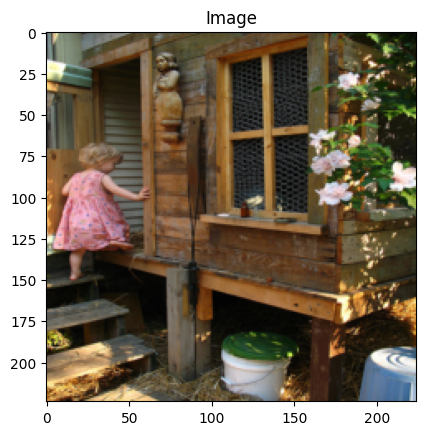

Token: tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12,  7, 13, 14, 15,  6, 16,  0, 17,
        18,  2])
Sentence:
['', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'UNK', 'way', '.', '']


In [10]:
# ADD YOUR CODE HERE
# Show some visualizations of the created dataset
img, caps = dataset[0]
print(caps)
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print(dataset.tokenizer.decode(caps))

Split your dataset into train, val and test sets

In [11]:
root_dir = 'data'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = FlickrDataset(root_dir, 'captions.txt', split='train', transform=transform, freq_threshold=5)
val_dataset = FlickrDataset(root_dir, 'captions.txt', split='val', transform=transform, freq_threshold=5)
test_dataset = FlickrDataset(root_dir, 'captions.txt', split='test', transform=transform, freq_threshold=5)

In [12]:
print(f'Train size: {len(train_dataset)}\nVal size: {len(val_dataset)}\nTest size: {len(test_dataset)}')

Train size: 32364
Val size: 4044
Test size: 4046


Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.  

In [13]:
def collate_fn(batch):
    images, captions = zip(*batch)
    padded_captions = []
    for caption in captions:
        caption = caption.tolist()
        if len(caption) < dataset.max_caption_length:
            caption += [dataset.tokenizer.pad_token_id] * (dataset.max_caption_length - len(caption))
        padded_captions.append(torch.tensor(caption))
    
    return torch.stack(images), torch.stack(padded_captions)

In [14]:
train_loader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=32, shuffle=True, num_workers=0, pin_memory=False)
val_loaded = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=32, shuffle=True, num_workers=0, pin_memory=False)
test_loader= DataLoader(test_dataset, collate_fn=collate_fn, batch_size=32, shuffle=True, num_workers=0, pin_memory=False)

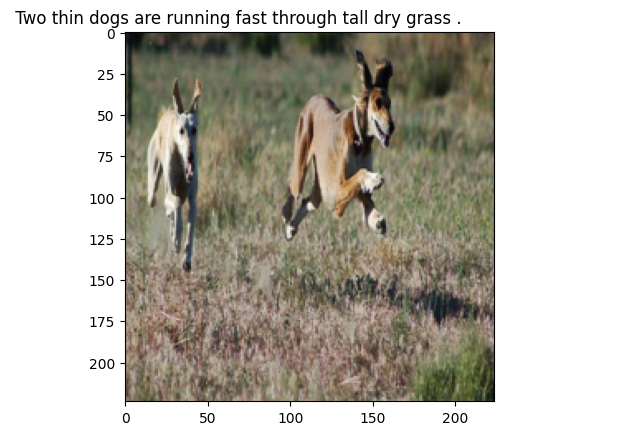

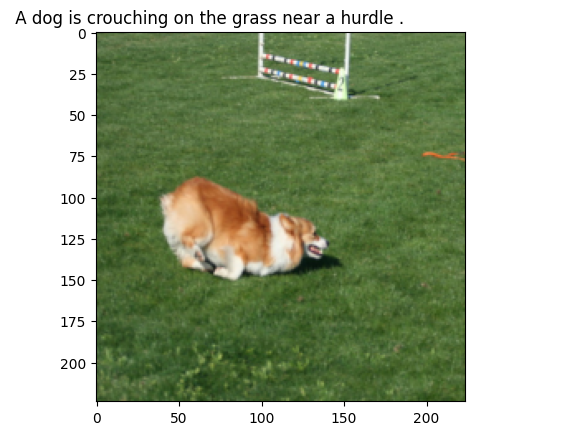

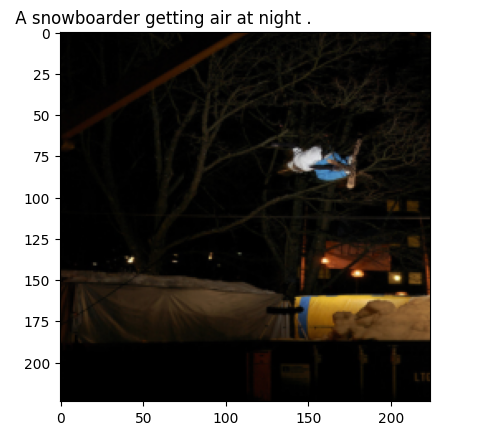

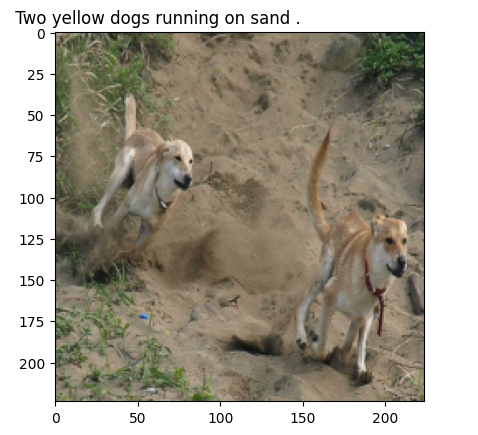

In [15]:
# Example of using the dataloader
count = 0
for batch in train_loader:
    for image, caption in zip(*batch):
        show_image(image, ' '.join(dataset.tokenizer.decode(caption)))
        count += 1
        if count == 4:
            break
    break

# 2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

In [16]:
# Use Apple M1 GPU if available, if not then use CUDA if available, else use CPU
device = torch.device('mps' if torch.mps.is_available() else torch.device('gpu') if torch.cuda.is_available() else 'cpu')
device

device(type='mps')

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [17]:
# ADD YOUR CODE HERE
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)

        # Remove 'fc' and 'avgpool' (last 2 layers)
        self.model = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze all layers up to layer2
        for name, param in resnet.named_parameters():
            if any(layer in name for layer in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2']):
                param.requires_grad = False
            else:
                param.requires_grad = True

        self.model.to(device)
        

    def forward(self, images):
        features = self.model(images)
        return features

In [18]:
# ADD YOUR CODE HERE
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim): #generous hint
        super(Attention, self).__init__()
        self.k = nn.Linear(encoder_dim, attention_dim)
        self.v = nn.Linear(encoder_dim, attention_dim)
        self.q = nn.Linear(decoder_dim, attention_dim)
        self.attention = nn.MultiheadAttention(embed_dim=attention_dim, num_heads=1)

    def forward(self, features, hidden_state): #generous hint
        # Project features and hidden state to the attention dimension
        keys = self.k(features)     # Shape: (batch_size, num_features, attention_dim)
        values = self.v(features) # Shape: (batch_size, num_features, attention_dim)
        queries = self.q(hidden_state.unsqueeze(1))  # Shape: (batch_size, 1, attention_dim)

        # MultiheadAttention expects (seq_len, batch_size, embed_dim)
        keys = keys.permute(1, 0, 2)   # Shape: (num_features, batch_size, attention_dim)
        values = values.permute(1, 0, 2)  # Shape: (num_features, batch_size, attention_dim)
        queries = queries.permute(1, 0, 2)  # Shape: (1, batch_size, attention_dim)

        # Compute attention
        attn_output, attn_weights = self.attention(queries, keys, values)  # attn_output: (1, batch_size, attention_dim)

        # Reshape outputs
        context = attn_output.squeeze(0)  # Shape: (batch_size, attention_dim)
        weights = attn_weights.squeeze(1)  # Shape: (batch_size, num_features)


        return context, weights #generous hint

In [42]:
# ADD YOUR CODE HERE
class Decoder(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim): #generous hint
        super(Decoder, self).__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(input_size=encoder_dim + embed_size, hidden_size=decoder_dim, batch_first=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # Initialize hidden state
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # Initialize cell state
        self.fc = nn.Linear(decoder_dim, vocab_size)

    def init_lstm_states(self, features):
        # Perform global average pooling across spatial dimensions
        global_features = features.mean(dim=[2, 3])
        h_0 = self.init_h(global_features).unsqueeze(0)  # Shape: (1, batch_size, decoder_dim)
        c_0 = self.init_c(global_features).unsqueeze(0)  # Shape: (1, batch_size, decoder_dim)
        return h_0, c_0

    def forward(self, features, captions): #generous hint
        batch_size = features.size(0)
        max_seq_len = captions.size(1)

        # Initialize LSTM states
        h, c = self.init_lstm_states(features)

        # Embed captions
        embeddings = self.embedding(captions)  # Shape: (batch_size, max_seq_len, embed_size)

        # Decode sequence
        outputs = []
        for t in range(max_seq_len):
            word_embedding = embeddings[:, t, :].unsqueeze(1)  # Shape: (batch_size, 1, embed_size)
            
            # Compute attention
            features = features.view(batch_size, -1, 2048)  # Shape: (8, 49, 2048)
            context, _ = self.attention(features, h[-1])  # context: (batch_size, encoder_dim)

            # Concatenate context and word embedding
            lstm_input = torch.cat([context.unsqueeze(1), word_embedding], dim=-1)  # Shape: (batch_size, 1, encoder_dim + embed_size)

            # Pass through LSTM
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))  # lstm_out: (batch_size, 1, decoder_dim)

            # Generate predictions
            output = self.fc(lstm_out.squeeze(1))  # Shape: (batch_size, vocab_size)
            outputs.append(output)

        # Stack all outputs
        outputs = torch.stack(outputs, dim=1)  # Shape: (batch_size, max_seq_len, vocab_size)
        return outputs


Combine the encoder - attention - decoder

In [43]:
class ImageCaptionModel(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim):
        super(ImageCaptionModel, self).__init__()
        self.embed_size = embed_size
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        
        self.encoder = Encoder()
        self.decoder = Decoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim)

    def forward(self, images, captions):
        features = self.encoder(images)
        predictions = self.decoder(features, captions)

        return predictions

In [44]:
device = 'mps'

In [45]:
model = ImageCaptionModel(embed_size = 256, vocab_size=len(train_dataset.tokenizer.get_vocab()), attention_dim=2048, encoder_dim=2048, decoder_dim=512)
model.to(device)

ImageCaptionModel(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
  

In [ ]:
# Example inputs
images = torch.randn(8, 3, 224, 224).to(device) # Batch of 8 images
captions = torch.randint(0, len(dataset.tokenizer.get_vocab()), (8, 20)).to(device)  # Batch of 8 caption sequences, max length 20

# Forward pass
predictions = model(images, captions)

In [48]:
# Apply softmax to get probabilities
probs = torch.softmax(predictions, dim=-1)  # Shape: (batch_size, seq_length, vocab_size)

# Get the predicted word indices by choosing the word with the highest probability at each time step
predicted_ids = torch.argmax(probs, dim=-1)  # Shape: (batch_size, seq_length)

In [50]:
predicted_text = [train_dataset.tokenizer.decode(ids) for ids in predicted_ids]

In [56]:
print(' '.join(predicted_text[0]))

Girls Street tools weeds offering bringing furry advertisement advertisement shoulder baseball dragon day tussle guitarist professional extends pink push bull


### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

In [30]:
# ADD YOUR CODE HERE
#Example of how to save a model (call this in the training loop)
def save_model(model, embed_size, attention_dim, encoder_dim, decoder_dim):
    model_state = {
        'embed_size':embed_size,
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'image_captioning.pth')


def train_model(model: ImageCaptionModel, train_loader: DataLoader, val_loader: DataLoader, optimizer: torch.optim.Optimizer, loss_fn, num_epochs=10):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        train_loss = 0.0

        model.train()

        # Batch
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + loss + backward + optimize
            output = model(inputs)

            loss = loss_fn(output, labels)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Divide by # of batches
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        
        # Batch       
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss =  loss_fn(outputs, labels)
                valid_loss += loss.item()
        
        valid_loss /= len(val_loader)
        val_losses.append(valid_loss)

        print(f'Epoch {epoch:02d}: train loss {train_loss:.4f}, valid loss {valid_loss:.4f}')
        save_model(model, model.embed_size, model.attention_dim, model.encoder_dim, model.decoder_dim)
    
    print('Finished training')
    return train_losses, val_losses


#In case of resuming training, make sure to load the architecture first
# model = Architecture()
#and then load the weights and other params
# model.load_state_dict(model_state['state_dict'])

Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

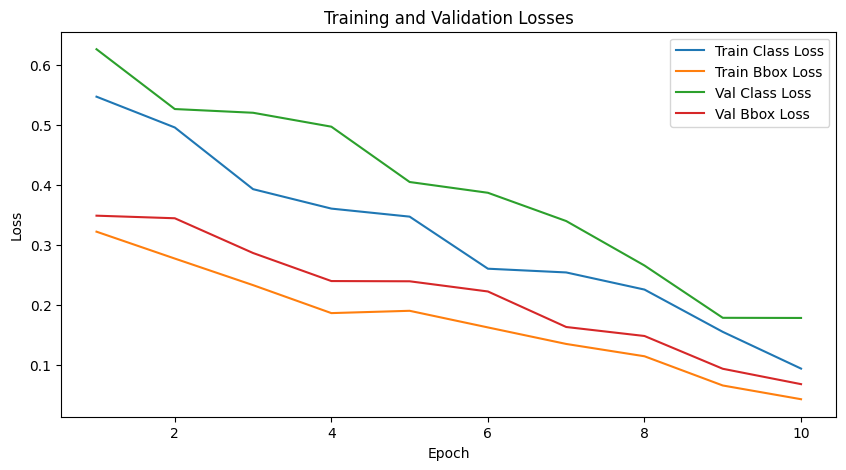

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=train_dataset.tokenizer.pad_token_id)  # Ignore padding tokens
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = ImageCaptionModel(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim)

train_losses, val_losses = train_model(...)
plot_losses(train_losses, val_losses)
# DO NOT TRY TO REPLICATE... this is an example

Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


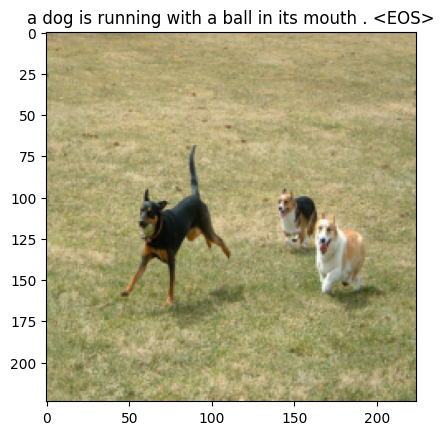

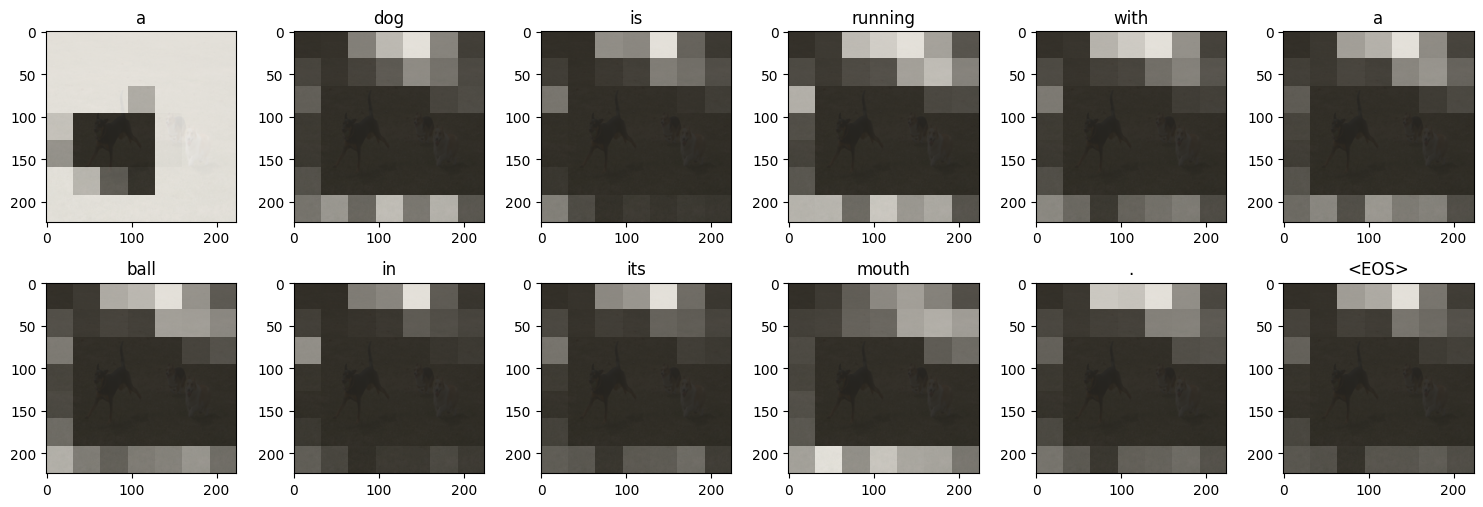

In [ ]:
# ADD YOUR CODE HERE

### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.

In [ ]:
# ADD YOUR CODE HERE

### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

In [ ]:
# ADD YOUR CODE HERE

### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step **2.3**.

In [ ]:
# ADD YOUR CODE HERE

# 3. COMPARISON
Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

In [ ]:
# ADD YOUR CODE HERE